In [1]:
import torch
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate, train_neural_net, draw_neural_net, visualize_decision_boundary

### Load Data
Prepare and standardize data

In [2]:
# Read file and store as pandas dataframe
filename = '../Data/day.csv'
df = pd.read_csv(filename)
df = df.drop('instant', axis=1)
df = df.drop('dteday', axis=1)
N, M = df.shape
attributeNames = list(df.columns)

# Undo the original max-min normalization
temp = df.columns.get_loc("temp")
atemp = df.columns.get_loc("atemp")
hum = df.columns.get_loc("hum")
windspeed = df.columns.get_loc("windspeed")

X = df.values
for row in range(0, N):
    X[row, temp] = X[row, temp]*(39-(-8)) + (-8)
    X[row, atemp] = X[row, atemp]*(50-(-16)) + (-16)
    X[row, hum] = X[row, hum]*100
    X[row, windspeed] = X[row, windspeed]*67

# Standarize ratio data attributes
temp_col = df.columns.get_loc("temp")
cnt_col = df.columns.get_loc("cnt")

for col in range(temp_col, cnt_col+1):
    # subtract mean, column by column
    mn = X[:, col].mean(0)
    std = np.std(X[:, col])
    X[:, col] = (X[:, col] - np.ones(N)*mn)/std

# Focus on the last 7 attributes
X = X[:,temp_col:cnt_col+1]
attributeNames = attributeNames[temp_col:cnt_col+1]

In [3]:
# Check standardization
print("mean cnt: ", X[:, 6].mean(0))
print("std cnt: ", np.std(X[:, 6]))
print(X.shape)

mean cnt:  -1.166417623682791e-16
std cnt:  0.9999999999999999
(731, 7)


### Set 'cnt' as target variable

In [4]:
cnt_col = attributeNames.index("cnt")
# Split dataset into features and target vector
y = X[:,cnt_col]
X = X[:,0:cnt_col]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

### 1. Regularized Linear Regression

In [5]:
# Values of lambda
lambdas = np.power(10.,np.linspace(-5,9,100))

### 2. Artificial Neural Network

In [6]:
# Define the ANN model structure
n_hidden_units = 3
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000

model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.MSELoss()
print('Training model of type:\n\n{}\n'.format(str(model())))

Training model of type:

Sequential(
  (0): Linear(in_features=7, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): Sigmoid()
)



### Cross Validation

In [7]:
# Cross validation
K = 3
CV = model_selection.KFold(K, shuffle=False)

# Initialize variables
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
Error_test_ANN = np.empty((K,1))

opt_h = np.zeros((K,1))                   # optimal ANN hidden units for each outer fold
opt_lambdas = np.empty((K,1))             # optimal lambdas for each outer fold
w_rlr = np.empty((M,K))                   # weights for each attribute with regularisation
w_noreg = np.empty((M,K))                 # weights for each attribute without regularisation
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))

### Training and Testing


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss


C:\Users\yufan\anaconda3\envs\course02450\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([487])) that is different to the input size (torch.Size([487, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		Final loss:
		724	0.9190451	9.728236e-07

	Best loss: 0.919045090675354


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		794	1.188382	9.028095e-07

	Best loss: 1.1883820295333862


Crossvalidation fold: 3/3

	Replicate: 1/1
		Iter	Loss			Rel. loss


C:\Users\yufan\anaconda3\envs\course02450\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([488])) that is different to the input size (torch.Size([488, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.80503786	5.6044802e-05
		2000	0.78891796	6.0441553e-06
		3000	0.78625745	2.0468133e-06
		Final loss:
		3526	0.78565896	9.862545e-07

	Best loss: 0.7856589555740356



Text(0.5, 1.0, 'Test mean-squared-error')

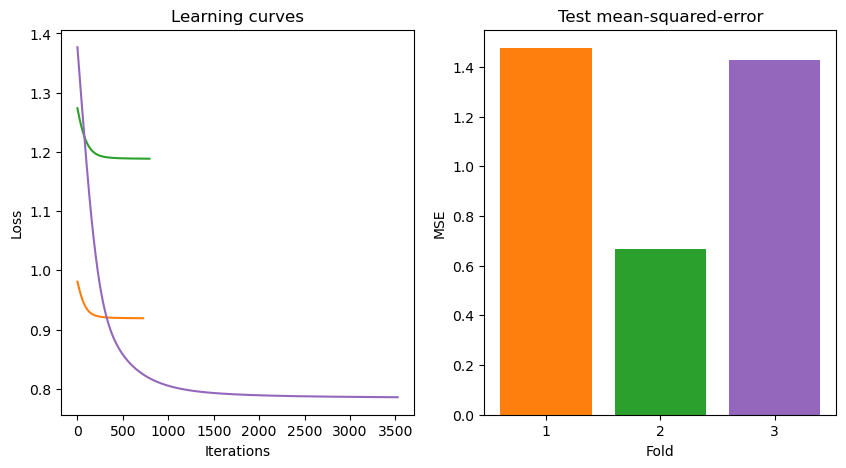

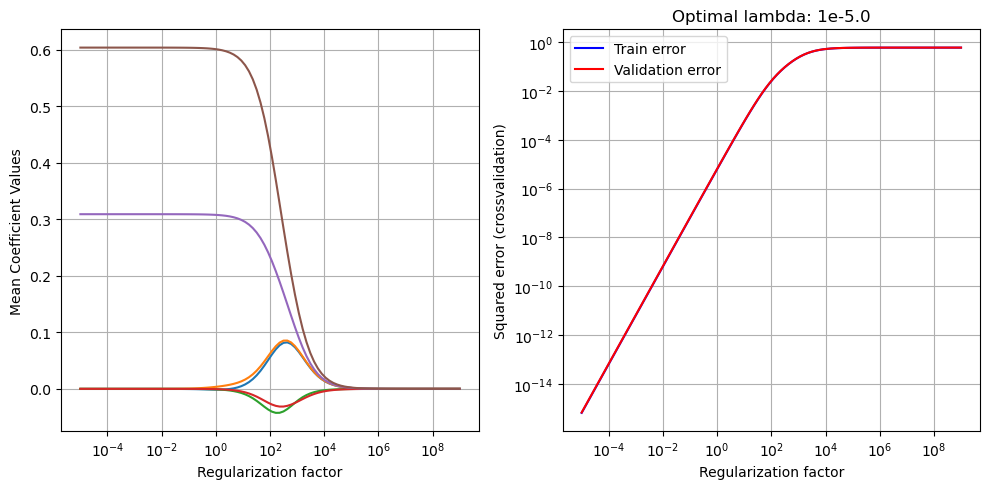

In [8]:
# Setup figure for display of ANN summaries
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5),num=2)
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']


for k, (train_index, test_index) in enumerate(CV.split(X,y)):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))
    internal_cross_validation = 3

    ############################### Lingear Regression ###############################
    # Extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    opt_val_err,opt_lambdas[k],mean_w_vs_lambda,train_err_vs_lambda,test_err_vs_lambda = \
    rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and std
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambdas[k] * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()

    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]

    ##################################### ANN #####################################
    # Extract test and train tensor sets to train ANN
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])

    # Train the net
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    print('\n\tBest loss: {}\n'.format(final_loss))

    # Determine estimated values for test set
    y_test_est = net(X_test)
    # Determine errors
    se = (y_test_est.squeeze().float()-y_test.float())**2         # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy()    # mean squared error
    Error_test_ANN[k] = mse                      # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
#     summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

#     # Display the results for the last cross-validation fold
    if k == K-1:
        reg_fig, reg_axes = plt.subplots(1, 2, figsize=(10,5),num=1)
        reg_axes[0].semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'-') # Don't plot the bias term
        reg_axes[0].set_xlabel('Regularization factor')
        reg_axes[0].set_ylabel('Mean Coefficient Values')
        reg_axes[0].grid()

        reg_axes[1].set_title('Optimal lambda: 1e{0}'.format(round(np.log10(opt_lambdas[k][0]),5)))
        reg_axes[1].loglog(lambdas,train_err_vs_lambda.T,'b-',lambdas,test_err_vs_lambda.T,'r-')
        reg_axes[1].set_xlabel('Regularization factor')
        reg_axes[1].set_ylabel('Squared error (crossvalidation)')
        reg_axes[1].legend(['Train error','Validation error'])
        reg_axes[1].grid()
        reg_fig.tight_layout()

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(Error_test_ANN)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE')
summaries_axes[1].set_title('Test mean-squared-error')

### Results of Linear Regression

In [9]:
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

Linear regression without feature selection:
- Training error: 7.537882938177872e-30
- Test error:     2.1990147818294565e-29
- R^2 train:     1.0
- R^2 test:     1.0

Regularized linear regression:
- Training error: 4.724022441508914e-16
- Test error:     1.1481441309779335e-15
- R^2 train:     0.9999999999999996
- R^2 test:     0.999999999999998



Text(0.5, 1.0, 'Weights from each fold of Regularized Linear Regression')

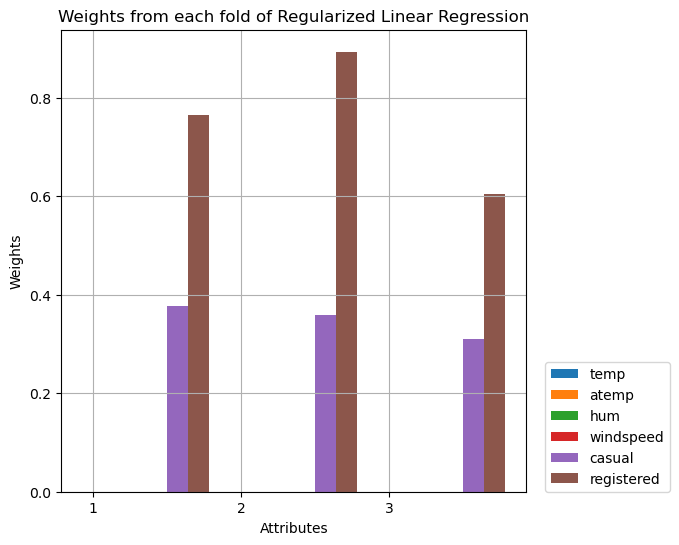

In [10]:
# Bar plot of RLR weights
weights = [1,2,3,4,5,6]      # skip offset
bw = 1.0/(len(weights)+1)
r = np.arange(1,K+1)

plt.figure(figsize=(6,6), num=3)
for i in weights:
    plt.bar(r+i*bw, w_rlr[i,:], width=bw)
plt.xticks(r+bw, range(1,K+1))
plt.xlabel('Attributes')
plt.ylabel('Weights')
plt.legend(attributeNames[1:M+1], loc=(1.04, 0))
plt.grid()
plt.title('Weights from each fold of Regularized Linear Regression')

### Results of ANN

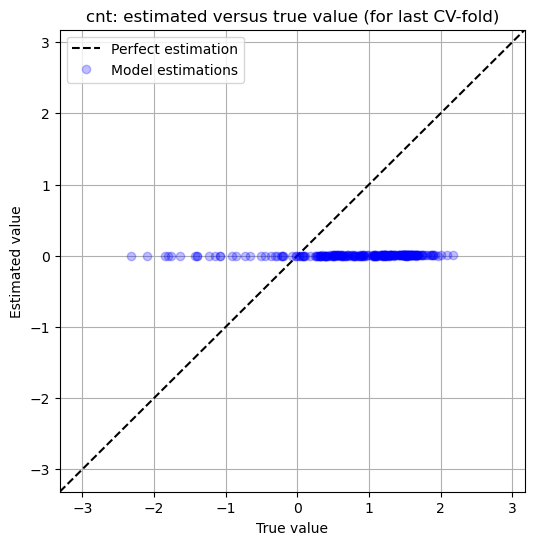

In [11]:
plt.figure(figsize=(6,6),num=5)
y_est = y_test_est.data.numpy().squeeze()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')           # perfect estimation
plt.plot(y_true, y_est,'ob',alpha=.25)          # ANN estimation
plt.legend(['Perfect estimation','Model estimations'])
plt.title('cnt: estimated versus true value (for last CV-fold)')
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

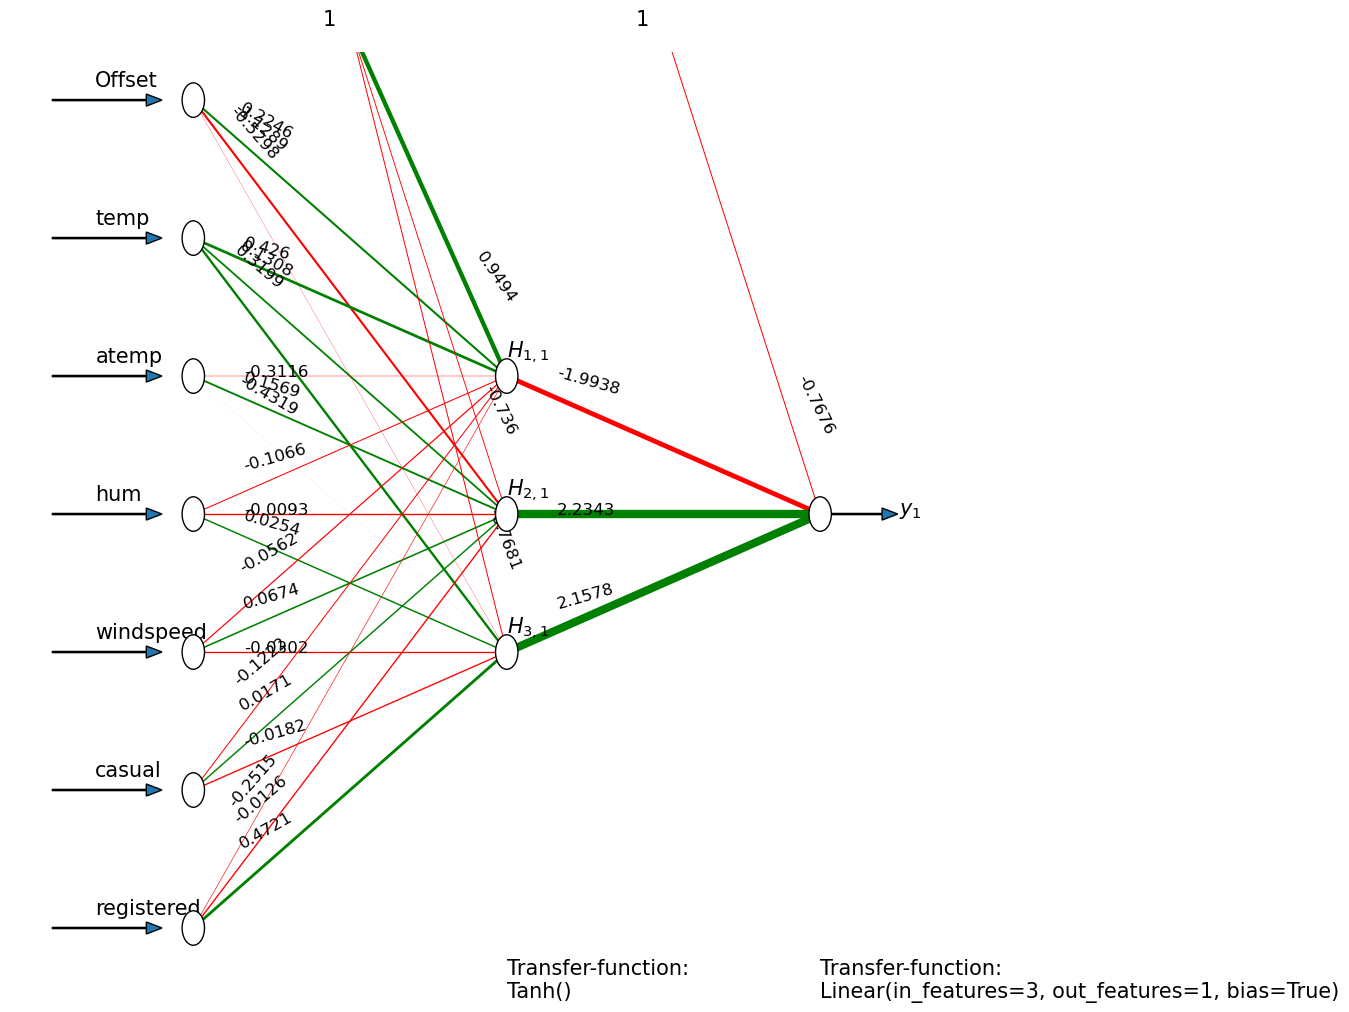

In [12]:
# Diagram of best neural net in last fold
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

plt.show()

### Table 2

In [13]:
print("Outer fold \tANN \t\t\tLinear Regression \t\tBaseline")
print("--------------------------------------------------------------------------------")
print("i \t\th∗_i \tEtest_i \tlambda_i \tEtest_i \tEtest_i")
for i in range(K):
    print("{} \t\t{:.3f} \t{:.3f} \t\t{:.2e} \t{:.3f} \t\t{:.3f}".format(\
        i+1,opt_h[i][0],Error_test_ANN[i].item(),opt_lambdas[i][0],\
            Error_test_rlr[i][0],Error_test_nofeatures[i][0]))

Outer fold 	ANN 			Linear Regression 		Baseline
--------------------------------------------------------------------------------
i 		h∗_i 	Etest_i 	lambda_i 	Etest_i 	Etest_i
1 		0.000 	1.475 		1.00e-05 	0.000 		0.592
2 		0.000 	0.669 		1.00e-05 	0.000 		0.540
3 		0.000 	1.425 		1.00e-05 	0.000 		0.695
